In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.fft as fft
import scipy as sp
import asp_func as f

# 1)
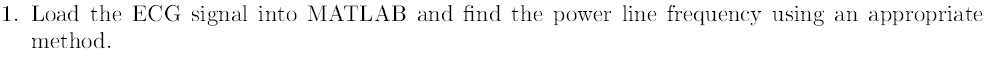

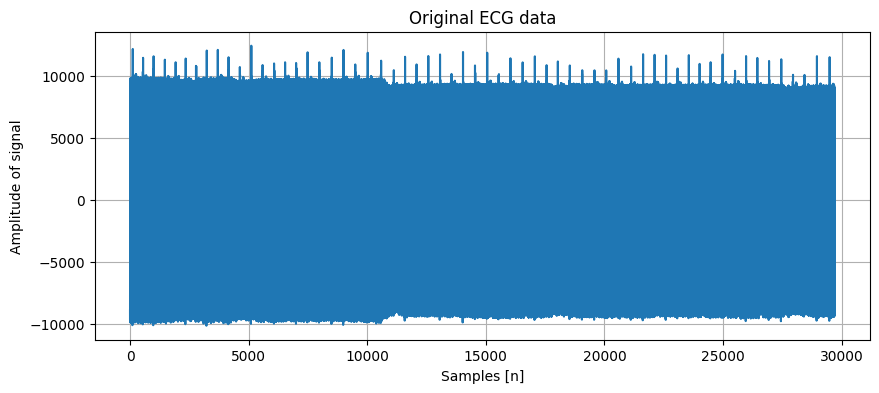

In [18]:
ecg_signal = np.loadtxt("ecg.dat") # Desired signal
N = len(ecg_signal)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ecg_signal)
ax.set_title("Original ECG data")
ax.set_xlabel("Samples [n]")
ax.set_ylabel("Amplitude of signal")
ax.grid()
plt.show()

# 2)



The filter taps should ideally cover at least one full cycle of the interference waveform (in this case, the 50 Hz powerline interference)
Given a sampling rate fs=500 Hzfs=500Hz, each cycle of the interference (50 Hz) corresponds to fs/f0=500/50=10fs/f0=500/50=10 samples per cycle.

In [19]:
fs = 500
f0 = 50
Nc = int(fs/f0)
Nc

10

# 3)
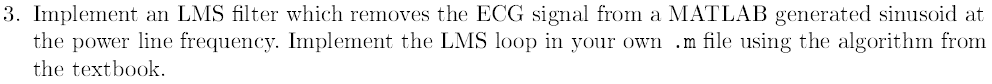

In [20]:
def LMS(x, d, order, step): #Takes data sequence (x), desired signal (d), number of filter taps (order), step-size (step)
    N = len(x)
    ws = np.zeros((N, order))
    ys = np.zeros(N)
    error = np.zeros(N)
    w = np.zeros(order)
    x_in = np.zeros(order)
    for k in range(N):
        ws[k] = w
        x_in = np.insert(x_in, 0, x[k])
        x_in = np.delete(x_in, -1)
        ys[k] = np.dot(w, x_in)
        error[k] = d[k] - ys[k]
        w = w + 2*step*error[k]*x_in
    return ws, ys, error

# 4)
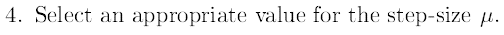

In [26]:
f0 = 50 #Powerline noise frequency
fs = 500 #Sampling frequency of system
n_samples = len(ecg_signal)
t = np.arange(n_samples) / fs

# Generate reference sinusoidal interference (50 Hz)
reference_signal_normal = np.cos(2 * np.pi * f0 * t)

#Autocorrelation matrix constructed
ACR, lags = f.autocorrelation(reference_signal_normal, Nc)
R = sp.linalg.toeplitz(np.flip(ACR[:Nc]))

#Maximum step-size determined from the trace of the autocorrelation matrix
μ_max = 1/(3*np.trace(R))
μ_max

np.float64(0.08240730639667648)

# 5)
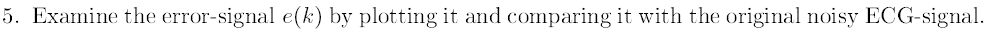

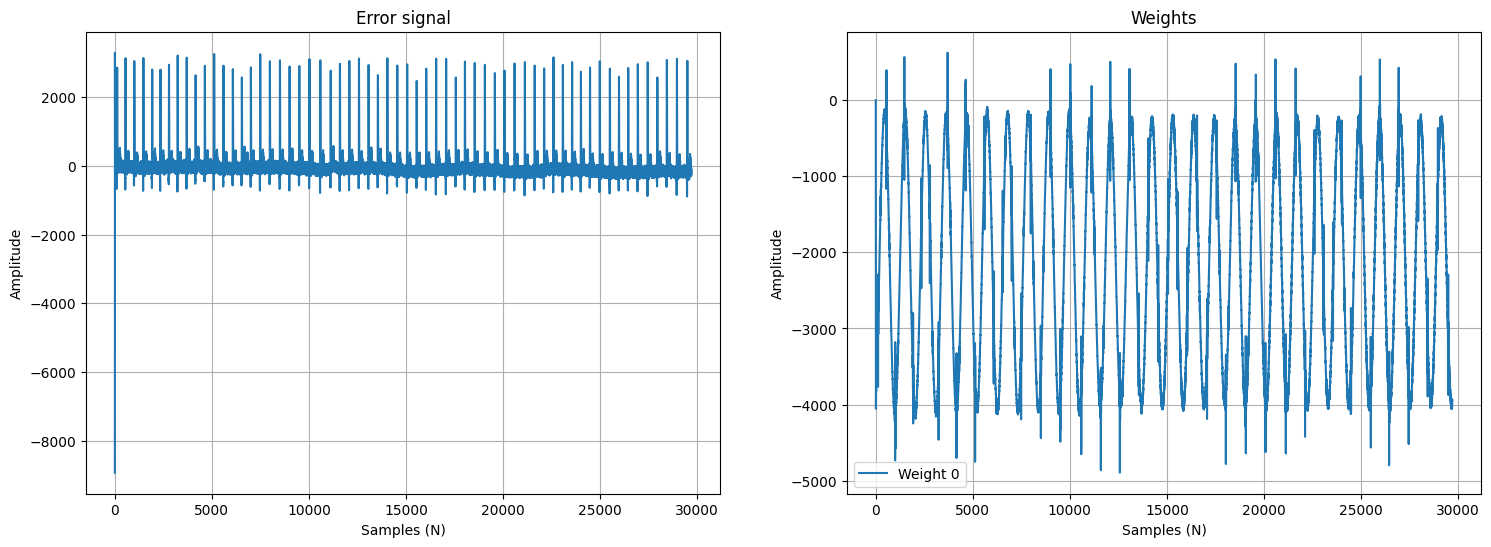

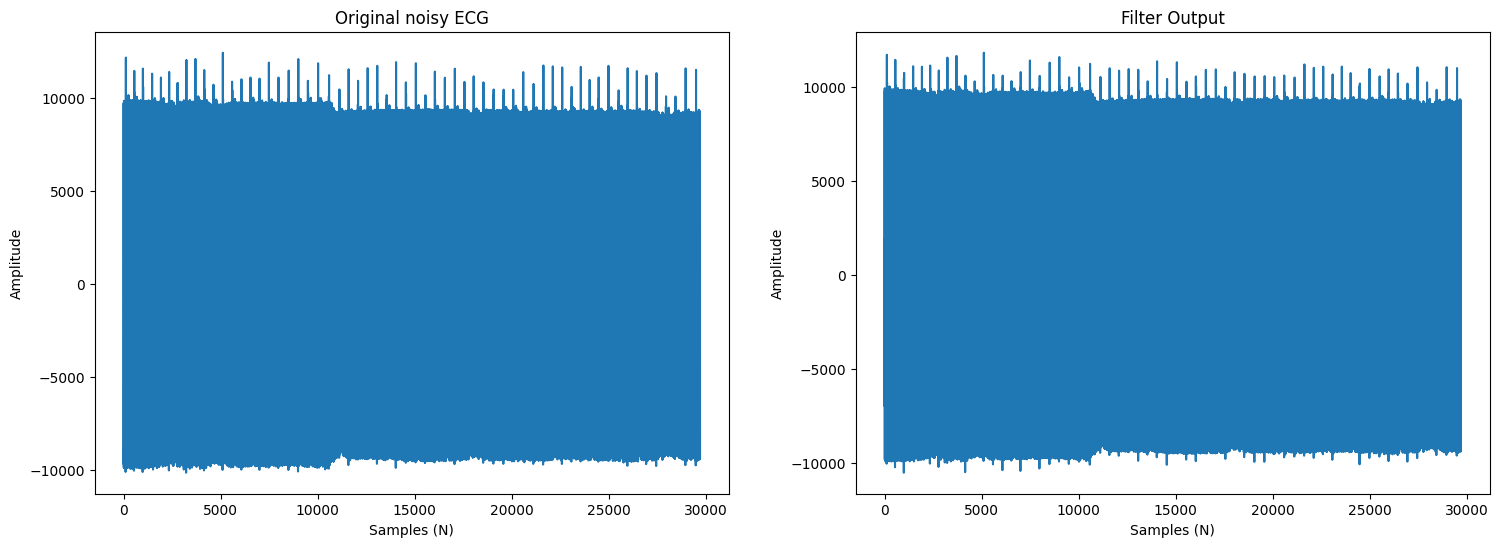

In [27]:
#Determined optimum weights with LMS
ws, ys, err = LMS(reference_signal_normal, ecg_signal, Nc, μ_max)

#From the plot below, we can see that we have strong oscillations in the weights over iterations. 
#It could indicate that 50 Hz is not being found. 
fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].plot(err)
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Samples (N)")
ax[0].set_title("Error signal")
ax[0].grid()
for w in range(1):
    ax[1].plot(ws[:,w], label=f"Weight {w}")
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Samples (N)")
ax[1].set_title("Weights")
plt.show()

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].plot(ecg_signal)
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Samples (N)")
ax[0].set_title("Original noisy ECG")
ax[1].plot(-ys)
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Samples (N)")
ax[1].set_title("Filter Output")
plt.show()

# 6)
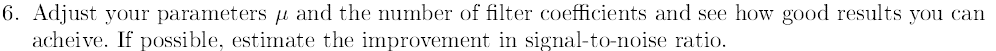

Frequency of maximum energy: 49.52695195447965


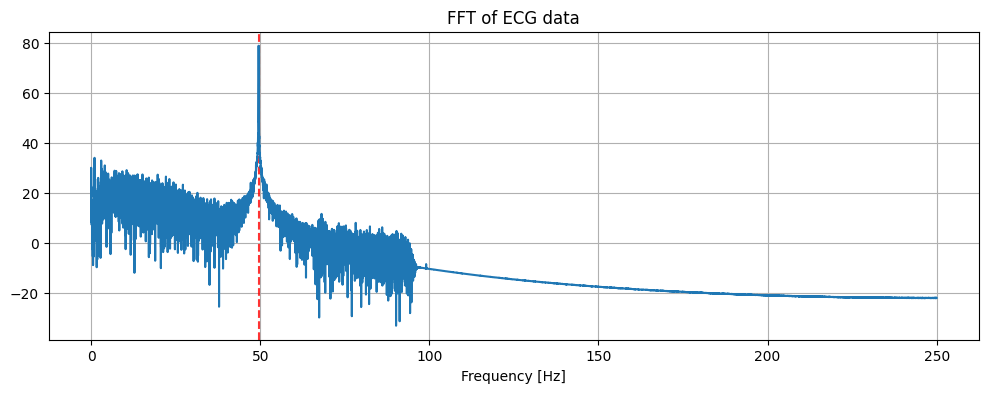

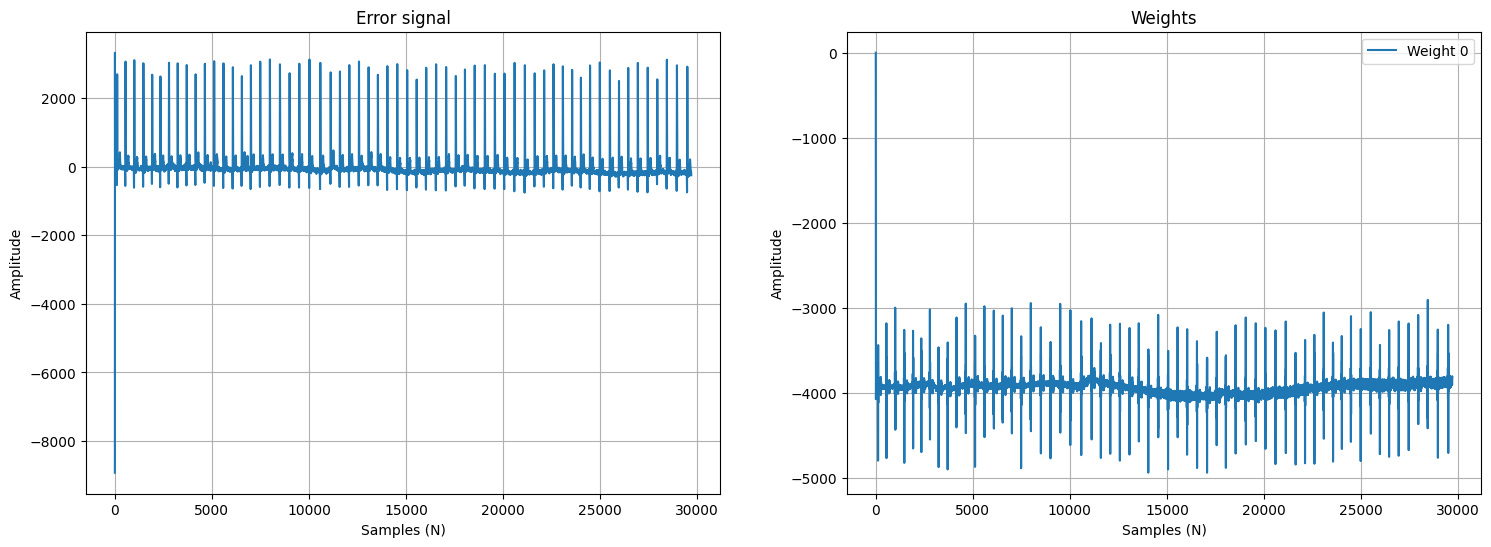

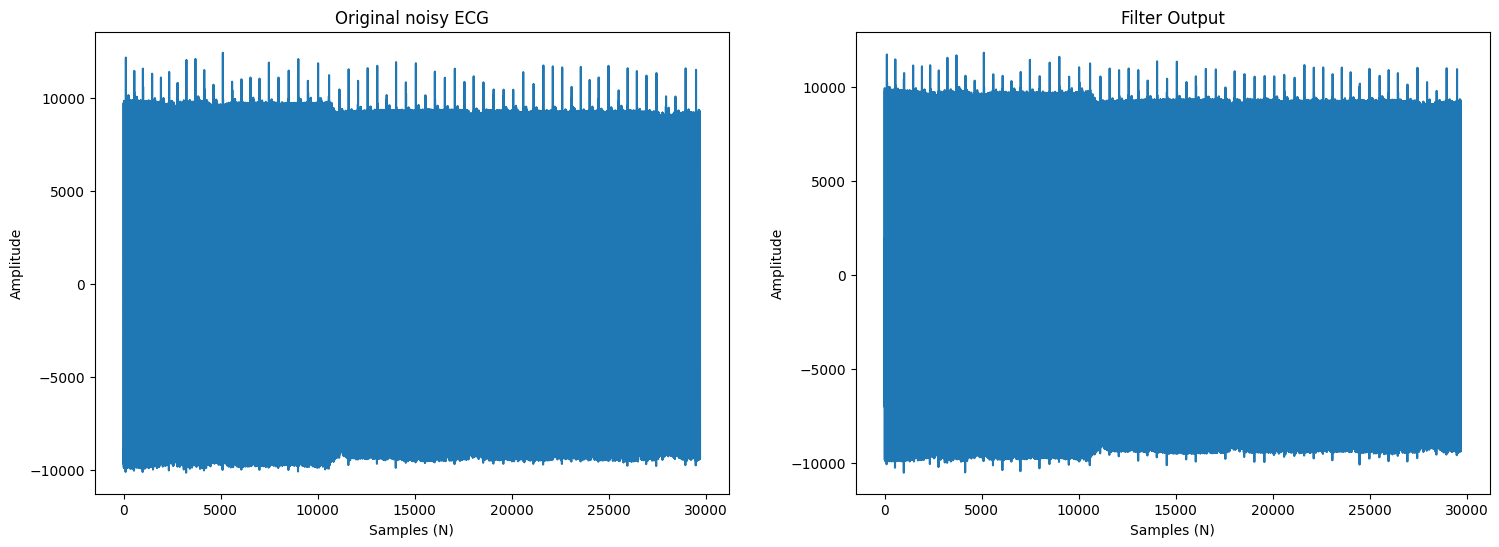

In [59]:
data_fft = fft.fft(ecg_signal)
fft_freq = fft.fftfreq(N, 1/fs)[:N//2]
fft_db = 20*np.log10(2.0/N * abs(data_fft[0:N//2]))

idx_max = np.argmax(fft_db)
freq_max = fft_freq[idx_max]
print("Frequency of maximum energy:",freq_max)

fig, ax = plt.subplots(figsize=(12,4))
ax.vlines(freq_max, 0, 1, transform=ax.get_xaxis_transform(), colors='r', linestyles='dashed', alpha=0.8)
ax.plot(fft_freq, fft_db)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("")
ax.set_title("FFT of ECG data")
ax.grid()
plt.show()

# Update the reference signal
f0 = freq_max
reference_signal_FFT = np.cos(2 * np.pi * f0 * t)

#Autocorrelation matrix constructed
ACR, lags = f.autocorrelation(reference_signal_FFT, Nc)
R = sp.linalg.toeplitz(np.flip(ACR[:Nc]))

#Maximum step-size determined from the trace of the autocorrelation matrix
μ_max = 1/(3*np.trace(R))
μ_max

# Determined optimum weights with LMS
ws2, ys2, err2 = LMS(reference_signal_FFT, ecg_signal, Nc, μ_max)

# From the plot below, we can see that we have strong oscillations in the weights over iterations. 
# It could indicate that 50 Hz is not being found. 
fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].plot(err2)
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Samples (N)")
ax[0].set_title("Error signal")
ax[0].grid()
for w in range(1):
    ax[1].plot(ws2[:,w], label=f"Weight {w}")
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Samples (N)")
ax[1].set_title("Weights")
plt.show()

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].plot(ecg_signal)
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Samples (N)")
ax[0].set_title("Original noisy ECG")
ax[1].plot(-ys2)
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Samples (N)")
ax[1].set_title("Filter Output")
plt.show()

In [31]:
def calculate_snr(signal, noise):
    """
    Calculate Signal-to-Noise Ratio (SNR) in dB.
    """
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

original_snr_normal = calculate_snr(ecg_signal, ecg_signal - reference_signal_normal)
original_snr_FFT = calculate_snr(ecg_signal, ecg_signal - reference_signal_FFT)
error1_snr = calculate_snr(ecg_signal, err)
error2_snr = calculate_snr(ecg_signal, err2)
snr_improvement1 = error1_snr - original_snr_normal
snr_improvement2 = error2_snr - original_snr_FFT
print("Original SNR = ", original_snr_normal)
print("FFT SNR = ", original_snr_FFT)
print("LMS denoise SNR1 = ", error1_snr)
print("LMS denoise SNR2 = ", error2_snr)
print("SNR improvement1 = ", snr_improvement1)
print("SNR improvement2 = ", snr_improvement2)
print("SNR tuned parameter diff = ", snr_improvement2-snr_improvement1)

Original SNR =  6.154922522515314e-07
FFT SNR =  -0.000855618454974967
LMS denoise SNR1 =  23.512051883402005
LMS denoise SNR2 =  23.768072018992985
SNR improvement1 =  23.512051267909754
SNR improvement2 =  23.76892763744796
SNR tuned parameter diff =  0.2568763695382046


# 7), 8), 9)
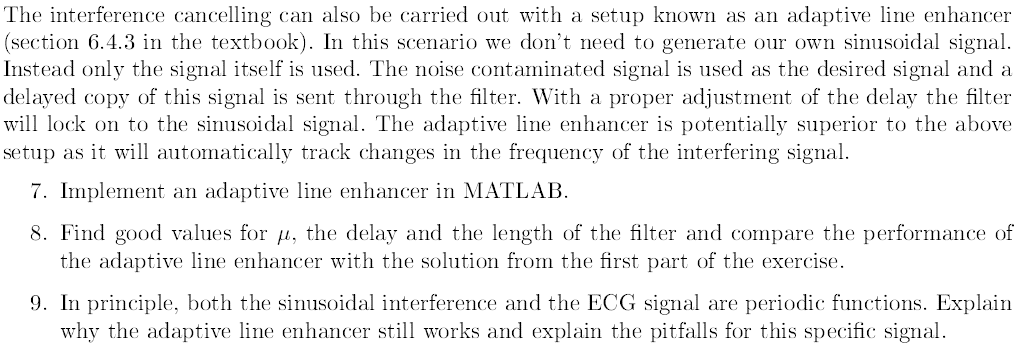

Max µ ALE =  5.667543763087422e-10
SNR Adapative Line Enhancer =  29.106512517076773
Improvements over LMS =  5.337584879628814


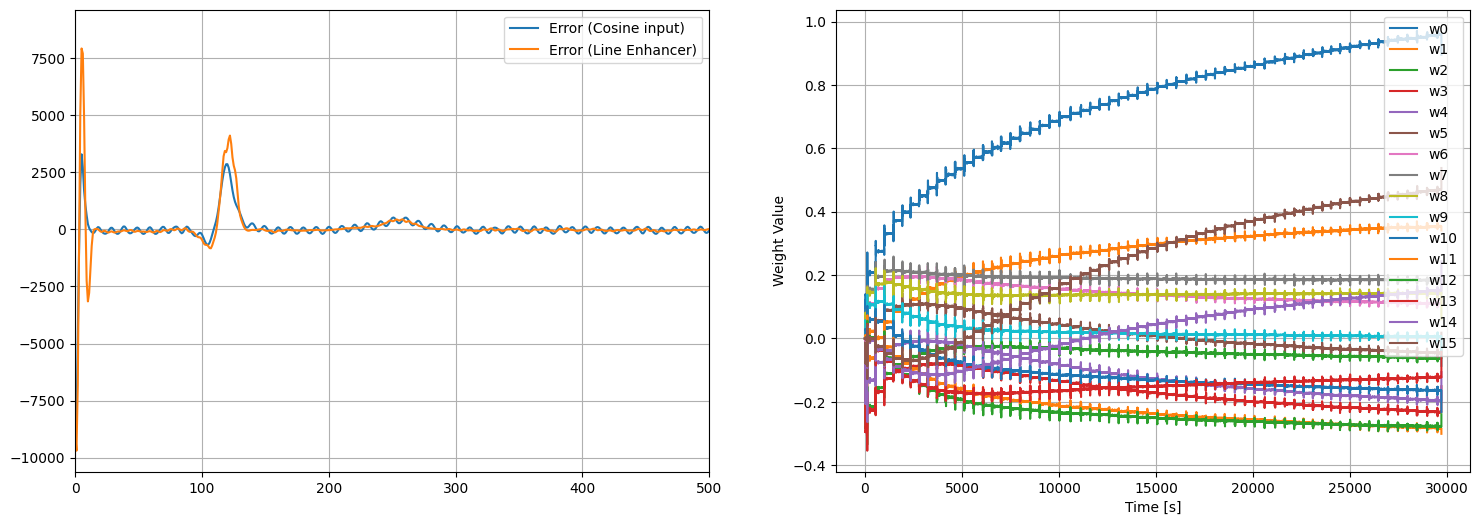

In [139]:
delay = 2
des = np.append(ecg_signal, [0]*delay) #Desired Signal
des_delay = np.insert(ecg_signal, 0, [0]*delay) #Input signal
Nc = 16

#Autocorrelation matrix constructed
ACR, lags = f.autocorrelation(des_delay, Nc)
R = sp.linalg.toeplitz(np.flip(ACR[:Nc]))

#Maximum step-size determined from the trace of the autocorrelation matrix
μ_max = 1/(3*np.trace(R))
μ_li = μ_max
print("Max µ ALE = ", µ_li)

ws_li, ys_li, err_li = LMS(des_delay, des, Nc, μ_li)

snr_ALE = calculate_snr(ecg_signal, err_li)
print("SNR Adapative Line Enhancer = ", snr_ALE)
print("Improvements over LMS = ", snr_ALE - snr_improvement2)

fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(err, label="Error (Cosine input)")
ax[0].plot(err_li, label="Error (Line Enhancer)")
ax[0].set_xlim(0,500)
ax[0].grid()
ax[0].legend()
for w in range(Nc):
    ax[1].plot(ws_li[:,w], label=f"w{w}")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Weight Value")
ax[1].legend()
ax[1].grid()
plt.show()

# 10) 
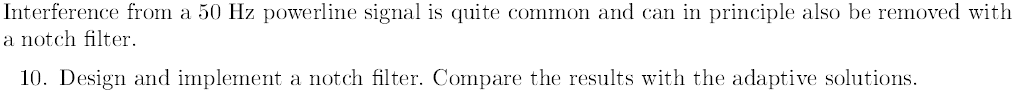

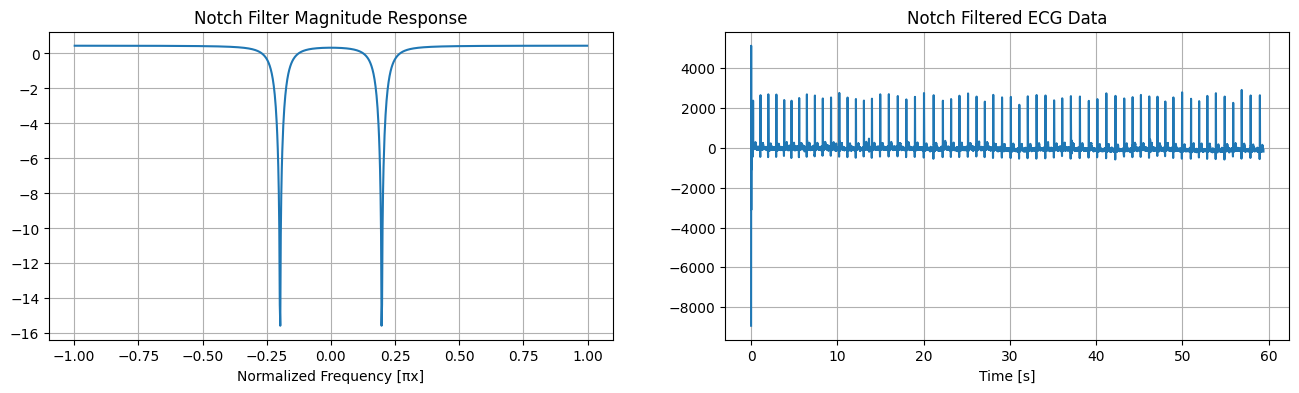

Frequency of maximum energy: 1.0100670011110737


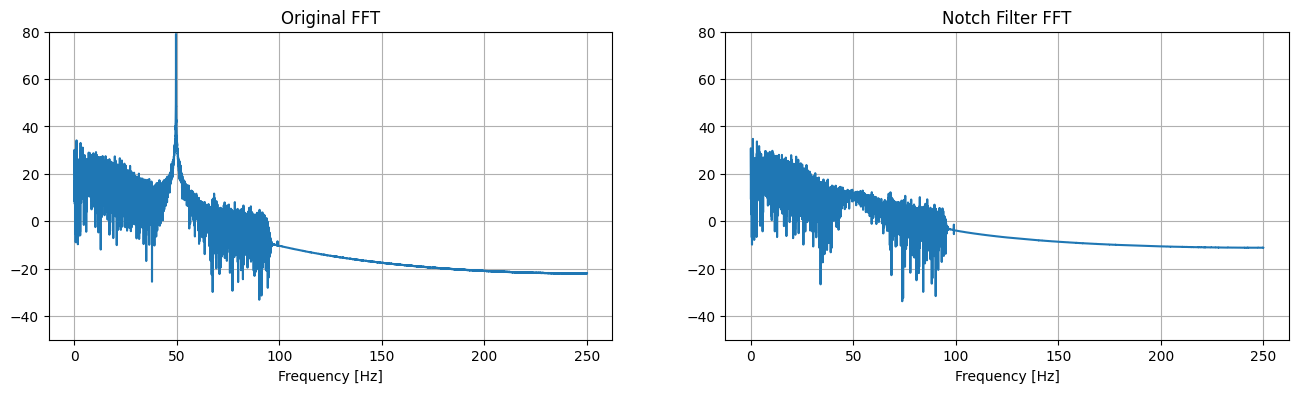

In [140]:
b0 = 1
Φ = (freq_max / 250)*np.pi #50/250π
r = 0.9
num_notch = np.array([1, -2*np.cos(Φ), 1]) * b0
den_notch = np.array([1, -2*r*np.cos(Φ), r**2])

ECG_notch = sig.lfilter(num_notch, den_notch, ecg_signal)

fig, ax = plt.subplots(1,2,figsize=(16,4))
f.plotMagResponse(num_notch, den_notch, db=True, ax=ax[0])
ax[0].grid()
ax[0].set_title("Notch Filter Magnitude Response")
ax[0].set_xlabel("Normalized Frequency [πx]")
ax[1].plot(t,ECG_notch)
ax[1].set_title("Notch Filtered ECG Data")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()

notch_fft = fft.fft(ECG_notch)
notch_freq = fft.fftfreq(N, 1/fs)[:N//2]
notch_db = 20*np.log10(2.0/N * abs(notch_fft[0:N//2]))

idx_max = np.argmax(notch_db)
notch_max = notch_freq[idx_max]
print("Frequency of maximum energy:",notch_max)

fig, ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(fft_freq, fft_db)
ax[0].set_ylim(-50,80)
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_title("Original FFT")
ax[0].grid()

ax[1].plot(notch_freq, notch_db)
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylim(-50,80)
ax[1].grid()
ax[1].set_title("Notch Filter FFT")
plt.show()

# 11)
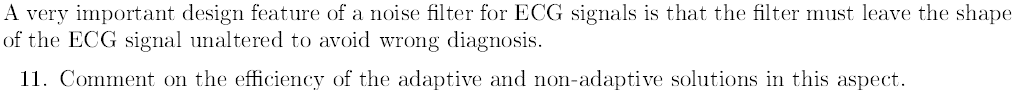

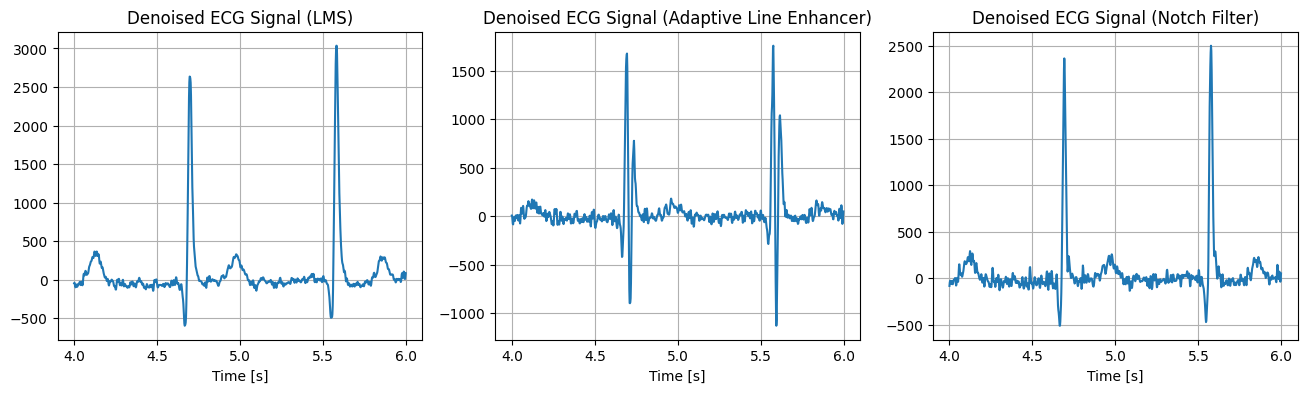

In [143]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(t[2000:3000], err2[2000:3000])
ax[0].set_title("Denoised ECG Signal (LMS)")
ax[0].set_xlabel("Time [s]")
ax[0].grid()
ax[1].plot(t[2000:3000], err_li[2000:3000])
ax[1].set_title("Denoised ECG Signal (Adaptive Line Enhancer)")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
ax[2].plot(t[2000:3000], ECG_notch[2000:3000])
ax[2].set_title("Denoised ECG Signal (Notch Filter)")
ax[2].set_xlabel("Time [s]")
ax[2].grid()